In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import array
from scipy.sparse import coo_matrix, csr_matrix
from matplotlib.pyplot import imshow, colorbar
from numpy.testing import assert_array_equal, assert_allclose, assert_almost_equal

## Read matrix generated from FreeFem++ script

In [2]:
def read_freefem_coo_matrix(matrix_file, print_shape=False):
    """
    Read from a file an sparse matrix as defined by FreeFem++
    
    Matrix is converted to the coo_matrix format of scipy.sparse
    """
    f = open(matrix_file, "r")
    reading_matrix_data = False
    reading_matrix_header = False
    I=[]
    J=[]
    V=[]
    for l in f.readlines():
        if not reading_matrix_data:
            if l[:7]=='# after': # Next line will contain matrix data
                reading_matrix_data = True
                reading_matrix_header = True
        else:
            if reading_matrix_header:
                # Read matrix header
                nrows, ncols, dummy, nnz = list( map (int, l.split()) )
                if print_shape:
                    print(f"nrows={nrows}, ncols={ncols}, nnz={nnz}")
                reading_matrix_header = False
                matrix_row = 0
            else:
                # Read matrix row, column, value
                lista_ijv = l.split()
                i=int(lista_ijv[0])
                j=int(lista_ijv[1])
                value=float(lista_ijv[2])
                I.append(i)
                J.append(j)
                V.append(value)
                matrix_row = matrix_row + 1
                if matrix_row == nnz:
                    break
    I = I-np.ones_like(I)
    J = J-np.ones_like(J)   
    #   print(f"I={I}")
    #   print(f"J={J}")
    return coo_matrix((V, (I,J)))

## Read matrix generated from FEniCS script

In [3]:
def read_fenics_coo_matrix(matrix_file, print_shape=False):
    """
    Read from a file a sparse matrix as defined by FEniCS (i,j, v(i,j))
    
    Matrix is converted to the coo_matrix format of scipy.sparse
    """
    f = open(matrix_file, "r")
    I=[]
    J=[]
    V=[]
    file_lines = f.readlines()  
    nnz = len(file_lines)
    nrows = ncols = int( file_lines[-1][0])
    if print_shape:
        print(f"nrows={nrows}, ncols={ncols}, nnz={nnz}")
    matrix_row = 0
    for l in file_lines:

        # Read matrix row, column, value
        lista_ijv = l.split()
        i=int(lista_ijv[0])
        j=int(lista_ijv[1])
        value=float(lista_ijv[2])
        I.append(i)
        J.append(j)
        V.append(value)
        matrix_row = matrix_row + 1
        if matrix_row == nnz:
            break  
    #   print(f"I={I}")
    #   print(f"J={J}")
    return  coo_matrix((V, (I,J)))

## Generic functions on COO matrices

In [4]:
def rows_sum(A):
    nrows, ncols = A.shape
    return array([ np.sum(A[i,:]) for i in range(nrows) ])
def cols_sum(A):
    nrows, ncols = A.shape
    return array([ np.sum(A[:,j]) for j in range(nrows) ])

def show_matrix_info(A, print_rows_sum=False, print_cols_sum=False, color_map='CMRmap'):            
    # * Plot matrix
    im=imshow(A, cmap=color_map)
    colorbar(im)
    plt.show()
    
    # * Print rows and columns sum
    if print_rows_sum:
        print("Sum of rows   :", end=" ")
        print(rows_sum(A))
    if print_cols_sum:
        print("Sum of columns:", end=" ")
        print(cols_sum(A))
        
def assert_symmetric(A): 
    "Comprobar que A es antidiagonal (excepción en caso contrario)"
    assert_almost_equal(A, A.transpose() ) 
    
def assert_antisymmetric(A): 
    "Comprobar que A es antidiagonal (excepción en caso contrario)"
    assert_almost_equal(A, np.diag(2*np.diagonal(A)) - A.transpose() )
    
def assert_diagonal(A):
    "Comprobar que A es diagonal"
    assert_almost_equal(A, np.diag(np.diagonal(A)))

def assert_zero_rows_sum(A):
    "Comprobar que todas las filas de A tienen suma cero"
    rsum = rows_sum(A)
    assert_almost_equal(np.zeros_like(rsum), rsum)
    
def assert_zero_cols_sum(A):
    "Comprobar que todas las columnas de A tienen suma cero"
    csum = cols_sum(A)
    assert_almost_equal(np.zeros_like(csum), csum)

## Objets to store FreeFem++ and FEniCS matrices

In [5]:
class MatrixContainer(object):
    def __init__(self, description, directory, file_reader):
        self.description = description
        self.directory = directory
        self.file_reader = file_reader
        self.matrix = {}
        
    def read_matrix(self, matrix_name, matrix_file):
        full_matrix_file = self.directory + matrix_file
        M = self.file_reader(full_matrix_file).toarray()
        self.matrix[matrix_name] = M
        return M
        
    def get_matrix(self, matrix_name):
        return self.matrix[matrix_name]
    
freefem = MatrixContainer("FreeFem++", "freefem/", read_freefem_coo_matrix)
fenics  = MatrixContainer("FEniCS", "fenics/", read_fenics_coo_matrix)

## Mass matrix

FreeFem++ mass matrix:


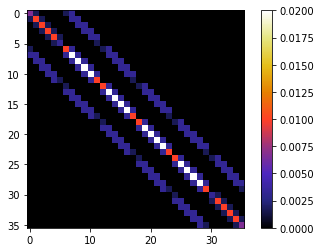

FEniCS mass matrix:


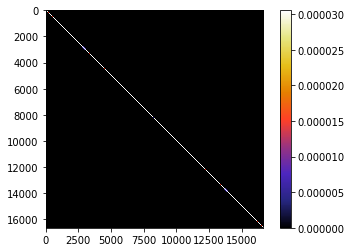

ValueError: operands could not be broadcast together with shapes (36,36) (16641,16641) 

In [6]:
freefem.matrix_dir = "freefem/"
fenics.matrix_dir = "fenics/"

for f in (freefem, fenics):
    f.read_matrix("M", "M.matrix.coo")

print("FreeFem++ mass matrix:")
M1 = freefem.get_matrix("M")
show_matrix_info(M1)

print("FEniCS mass matrix:")
M2 = fenics.get_matrix("M")
show_matrix_info(M2)

Mdiff = M1-M2
print("Difference of mass matrices:")
show_matrix_info(M1-M2)

## Lumped (low order) mass matrix

FreeFem++ mass matrix:


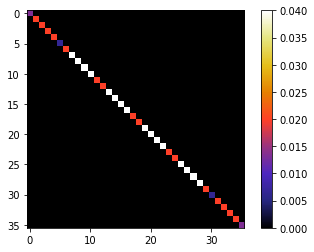

FEniCS mass matrix:


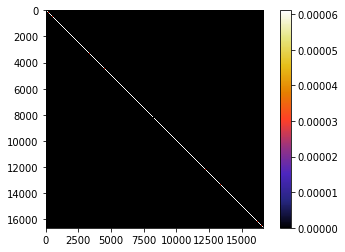

Difference of mass matrices:


ValueError: operands could not be broadcast together with shapes (36,36) (16641,16641) 

In [7]:
for f in (freefem, fenics):
    f.read_matrix("ML", "ML.matrix.coo")

print("FreeFem++ mass matrix:")
A1 = freefem.get_matrix("ML")
show_matrix_info(A1)

print("FEniCS mass matrix:")
A2 = fenics.get_matrix("ML")
show_matrix_info(A2)

print("Difference of mass matrices:")
show_matrix_info(A1-A2)

## Diffusion matrix, L

FreeFem++ diffusion matrix:


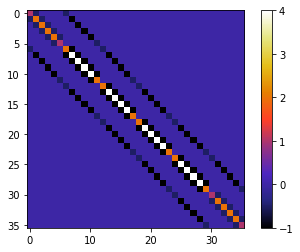

FEniCS diffusion matrix:


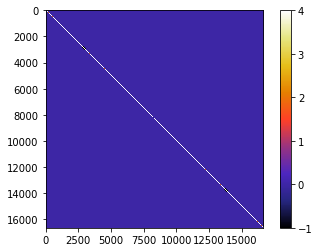

Difference of diffusion matrices:


ValueError: operands could not be broadcast together with shapes (36,36) (16641,16641) 

In [8]:
for f in (freefem, fenics):
    f.read_matrix("L", "L.matrix.coo")

print("FreeFem++ diffusion matrix:")
A1 = freefem.get_matrix("L")
show_matrix_info(A1)

print("FEniCS diffusion matrix:")
A2 = fenics.get_matrix("L")
show_matrix_info(A2)

print("Difference of diffusion matrices:")
show_matrix_info(A1-A2)

## Convection matrix

In [9]:
def plot_matrix(matrix, positive_and_negative=True, title=''):
    fig = plt.figure()
    size_x = 11 if positive_and_negative else 8
    size_y = 6
    fig.set_size_inches(size_x, size_y)

    if positive_and_negative:
        ax1 = plt.subplot2grid((2, 3), (0, 2), colspan=1)
        im1 = ax1.imshow(np.where(matrix>0, matrix, 0), cmap='Reds')
        plt.colorbar(im1)
        plt.title("Positive part")

        ax2 = plt.subplot2grid((2, 3), (1, 2), colspan=1)
        im2 = ax2.imshow(np.where(matrix<0, matrix, 0), cmap='bone')
        plt.colorbar(im2)
        plt.title("Negative part")

    grid_x_y = (2,3) if positive_and_negative else (1,1)
    rows = cols = grid_x_y[0]
    ax3= plt.subplot2grid(grid_x_y, (0, 0), rowspan=rows, colspan=cols)
    im3 =ax3.imshow(matrix, cmap='CMRmap')
    plt.colorbar(im3)
    plt.title("Matrix values")
    
    plt.suptitle(title, fontsize=16)
    fig.show()

/usr/lib/python3/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


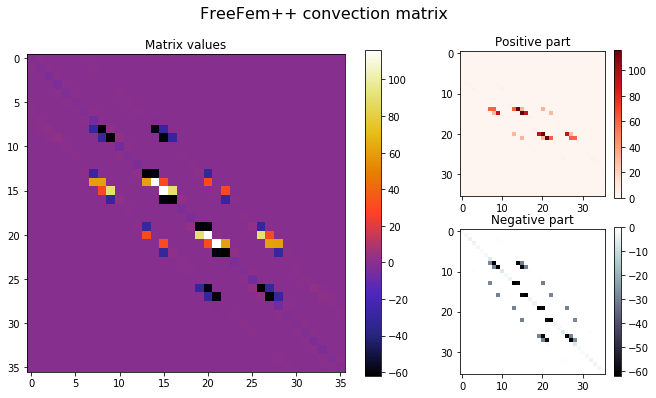

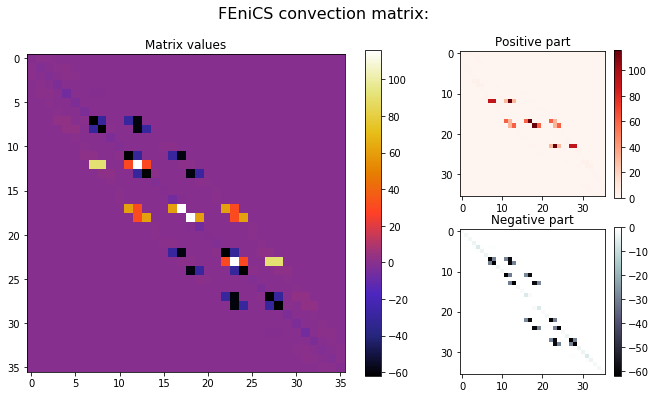

In [10]:
for f in (freefem, fenics):
    f.read_matrix("K", "K.matrix.coo")

K1 = freefem.get_matrix("K")
plot_matrix(K1, title="FreeFem++ convection matrix")
assert_zero_cols_sum(K1) # Comprobar que la suma por columnas es cero

K2 = fenics.get_matrix("K")
plot_matrix(K2, title="FEniCS convection matrix:")
assert_zero_cols_sum(K2) # Comprobar que la suma por columnas es cero

## Artificial diffusion matrix, D 

D will be added to convection matrix, K (obtaining KL=K+D), in order to eliminate all negative off-diagonal entries.


**Property**: D is "anti-diffusive", i.e.,
- Extra-diagonal elements are positive
- Diagonal elements of L are negative, specifically: 
    $a_{ii}=-\sum_{j\neq i} a_{ij}$)


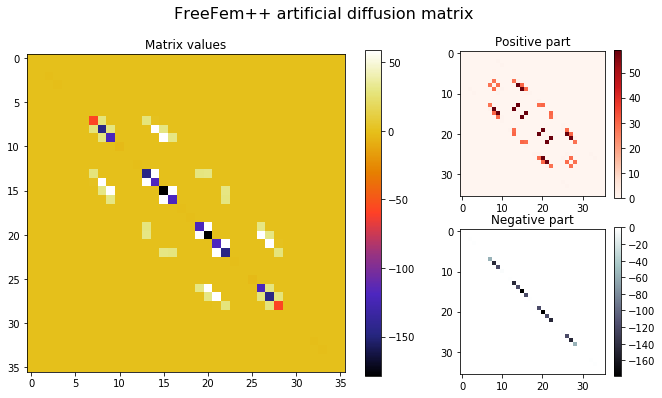

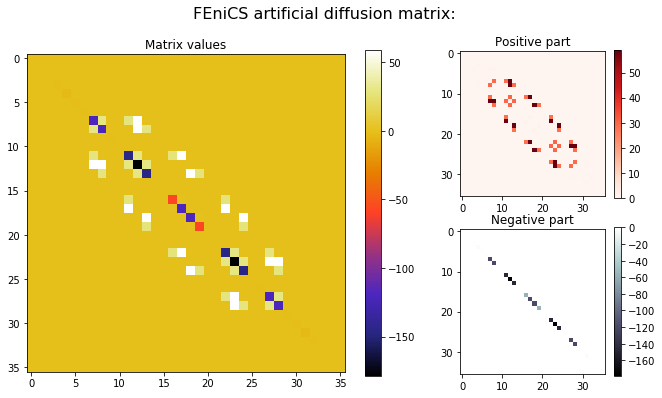

In [11]:
for f in (freefem, fenics):
    f.read_matrix("D", "D.matrix.coo")

D1 = freefem.get_matrix("D")
plot_matrix(D1, title="FreeFem++ artificial diffusion matrix")

D2 = fenics.get_matrix("D")
plot_matrix(D2, title="FEniCS artificial diffusion matrix:")

# La matriz es simétrica
assert_symmetric(D1); assert_symmetric(D2)
# La suma de las columnas tiene que ser cero!
assert_zero_cols_sum(D1); assert_zero_cols_sum(D2)
# La suma de las filas tiene que ser cero!
assert_zero_rows_sum(D1); assert_zero_rows_sum(D2)

print(r"""
**Property**: D is "anti-diffusive", i.e.,
- Extra-diagonal elements are positive
- Diagonal elements of L are negative, specifically: 
    $a_{ii}=-\sum_{j\neq i} a_{ij}$)""")

## Corrected diffusion matrix, KL=K+D

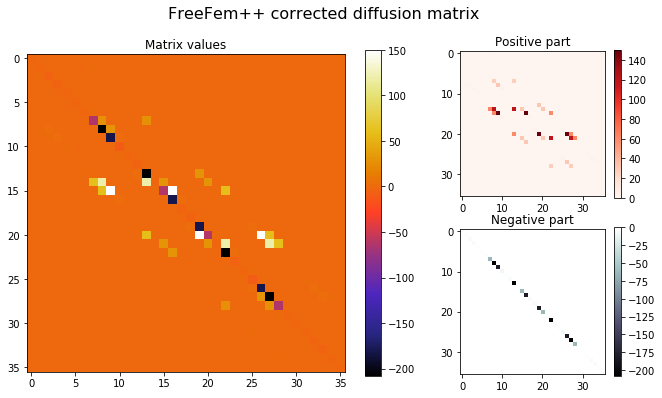

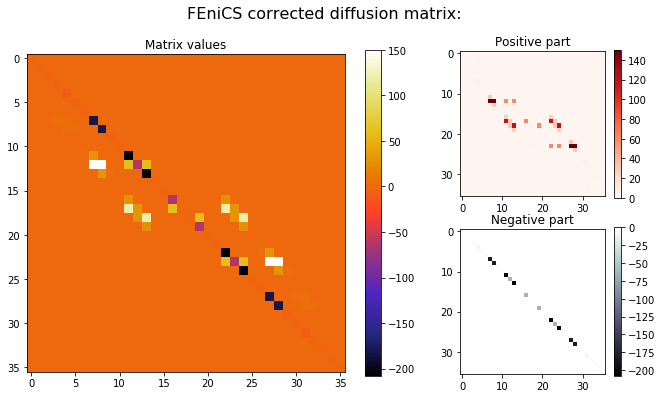

In [12]:
for f in (freefem, fenics):
    f.read_matrix("KL", "KL.matrix.coo")

KL1 = freefem.get_matrix("KL")
plot_matrix(KL1, title="FreeFem++ corrected diffusion matrix")

KL2 = fenics.get_matrix("KL")
plot_matrix(KL2, title="FEniCS corrected diffusion matrix:")

# Error si $KL \neq K+D$:
assert_almost_equal(KL1, K1+D1); assert_almost_equal(KL2, K2+D2)

# Comprobar que las suma por columnas es cero
assert_zero_cols_sum(KL1); assert_zero_cols_sum(KL2)

# "Raw" flux matrix F_pre

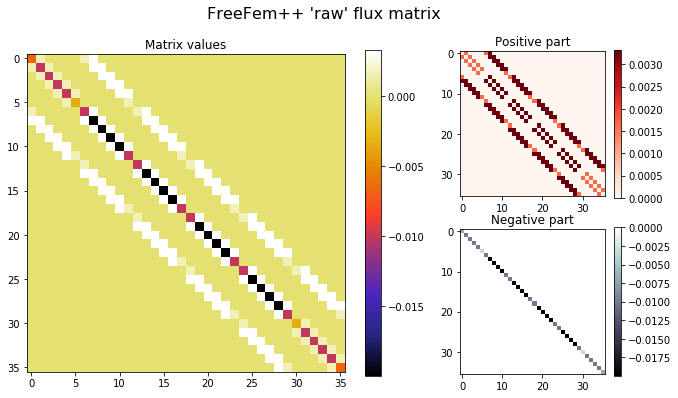

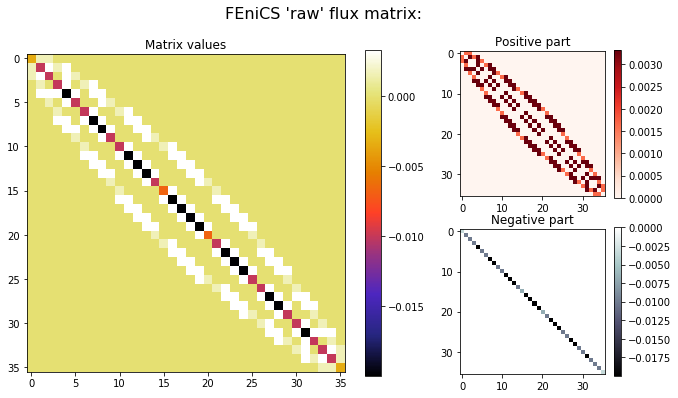

In [13]:
for f in (freefem, fenics):
    f.read_matrix("FF_pre", "FF_previous.matrix.coo")

FF1 = freefem.get_matrix("FF_pre")
plot_matrix(FF1, title="FreeFem++ 'raw' flux matrix")

FF2 = fenics.get_matrix("FF_pre")
plot_matrix(FF2, title="FEniCS 'raw' flux matrix:")

# Corrected flux matrix, F 

$F_{ij}=0$ if $F_{ij}(u_j-u_i) > 0$


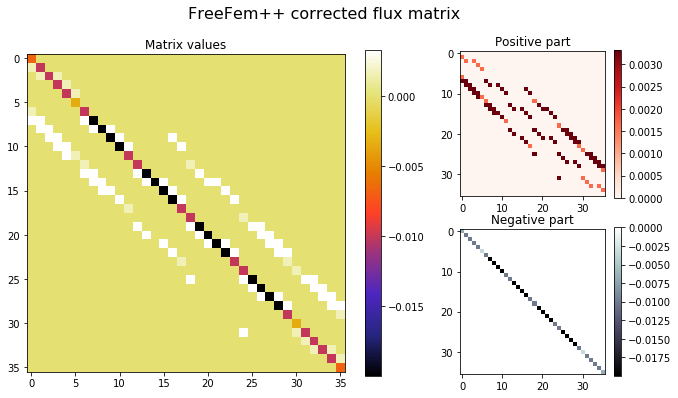

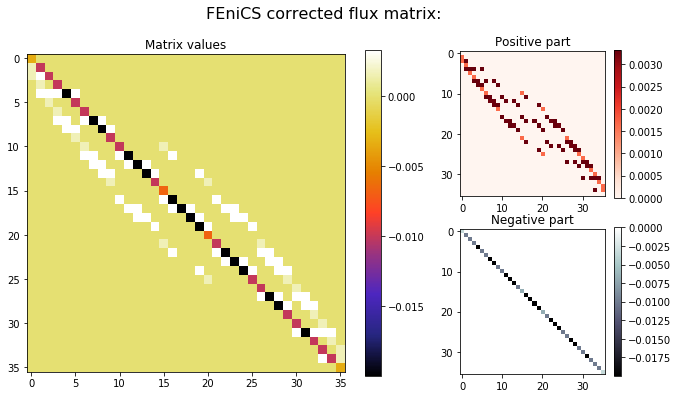

In [14]:
for f in (freefem, fenics):
    f.read_matrix("FF", "FF.matrix.coo")

FF1 = freefem.get_matrix("FF")
plot_matrix(FF1, title="FreeFem++ corrected flux matrix")

FF2 = fenics.get_matrix("FF")
plot_matrix(FF2, title="FEniCS corrected flux matrix:")

# Cálculos con los elementos de F

## 1. Pplus y Pminus


In [17]:
F=FF1 # Fenics flux matrix
print(type(F))
n = len(F)
Pplus = np.empty(n)
for i in range(n):
    F0 = F[i, :i]    # Values of F in row i before column i
    #print(f"F0={F0}")
    F1 = F[i, i+1:]   # Values of F in row i after column i
    #print(f"F1={F1}")
    max0 = max(np.maximum(F0,0)) if len(F0)>0 else 0
    max1 = max(np.maximum(F1,0)) if len(F1)>0 else 0
    Pplus[i] = max( max0, max1 )
Pplus

<class 'numpy.ndarray'>


array([0.        , 0.00166667, 0.0016666 , 0.00166667, 0.00166667,
       0.        , 0.00166667, 0.00333333, 0.00333332, 0.00333321,
       0.00333333, 0.00333332, 0.0016666 , 0.00333332, 0.00333333,
       0.00330324, 0.00333321, 0.00166667, 0.00166667, 0.00333321,
       0.00330324, 0.00333333, 0.00333332, 0.0016666 , 0.00166667,
       0.00333333, 0.00333321, 0.00333332, 0.00333333, 0.00166667,
       0.        , 0.00333332, 0.00166667, 0.0016666 , 0.00166667,
       0.        ])

# Matriz de coeficientes, $\alpha_{i,j}$

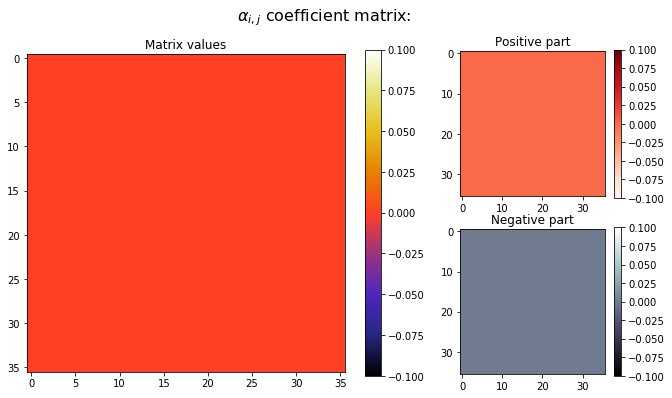

In [24]:
for f in (fenics,):
    f.read_matrix("alpha", "alpha.matrix.coo")

#FF1 = freefem.get_matrix("FF")
#plot_matrix(FF1, title="FreeFem++ corrected flux matrix")

alpha = fenics.get_matrix("alpha")
plot_matrix(alpha, title=r"$\alpha_{i,j}$ coefficient matrix:")